In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Ntrain = train_input_100.size(0)
Ntest = test_input_100.size(0)
Nchannels = train_input_100.size(1)
Nsamples_100 = train_input_100.size(-1)
Nsamples_1000 = train_input_1000.size(-1)

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

In [3]:
class conv2DNet(nn.Module):
    
    def __init__(self, Nchannels, Nsamples, output_units):
        """Initializes neural network with 3 convolutional layers and 1 fully-connected layer.
        
        Args:
            - Nchannels (int): number of EEG channels
            - Nsamples (int): number of time points in each EEG signal
            - output_units (int): number of output units, e.g. 1 for training with loss torch.nn.BCELoss or 2 with 
            loss torch.nn.CrossEntropyLoss            
            
            """
        super(conv2DNet, self).__init__()
        # Layer 1
        l1_channels = 16  
        self.conv1 = nn.Conv2d(1, l1_channels, (Nchannels, 1), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(l1_channels, False) # final size bsize x 1 x l1_channels x Nsamples

        # Layer 2
        l2_channels = 4
        l2_temp_window = 32
        l2_l1channel_overlap = 2
        self.padding1 = nn.ZeroPad2d((l2_temp_window // 2, l2_temp_window // 2 - 1, l2_l1channel_overlap//2-1, l2_l1channel_overlap//2)) # left, right, top, bottom
        self.conv2 = nn.Conv2d(1, l2_channels, (l2_l1channel_overlap, l2_temp_window))  # does not change size if combined with above padding
        self.batchnorm2 = nn.BatchNorm2d(l2_channels, False)
        self.pooling2 = nn.MaxPool2d((2, 4)) # final size bsize x l2_channels x floor(l1_channels/2) x floor(Nsamples/4)

        # Layer 3
        l3_channels = 4
        l3_temp_window = 4
        l3_l2channel_overlap = 8
        self.padding2 = nn.ZeroPad2d((l3_temp_window//2, l3_temp_window//2-1, l3_l2channel_overlap//2, l3_l2channel_overlap//2-1))
        self.conv3 = nn.Conv2d(l2_channels, l3_channels, (l3_l2channel_overlap, l3_temp_window))
        self.batchnorm3 = nn.BatchNorm2d(l3_channels, False)
        self.pooling3 = nn.MaxPool2d((2, 4)) # final size bsize x l3_channels x floor(l1_channels/4) x floor(Nsamples/16)

        # FC Layer
        fc_inputs = l3_channels * (l1_channels//4) * (Nsamples//16)
        self.fc1 = nn.Linear(fc_inputs, output_units)
        
        
    def forward(self, x):
        """Applies forward pass consisting of 3 convolutional layers followed by a fully-connected linear layer.
        
        Args:
            - x (torch.autograd.Variable): the input batch. It has dimension batch_size x Nchannel x Nsamples x 1,
            where Nchannel is the number of EEG channels and Nsamples the number of time points.
        
        Returns:
            - (torch.autograd.Variable) of size either batch_size x output_units   
        
        """
        x = x.permute(0, 3, 1, 2)             # bsize x 1 x Nchannels x Nsamples
        
        # Layer 1
        x = F.relu(self.conv1(x))              # bsize x l1_channels x 1 x Nsamples
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.3)
        x = x.permute(0, 2, 1, 3)             # bsize x 1 x l1_channels x Nsamples

        # Layer 2
        x = self.padding1(x)
        x = F.relu(self.conv2(x))              # bsize x l2_channels x l1_channels x Nsamples
        x = self.batchnorm2(x)       
        x = F.dropout(x, 0.3)
        x = self.pooling2(x)                  # bsize x l2_channels x floor(l1_channels/2) x floor(Nsamples/4)

        # Layer 3
        x = self.padding2(x)
        x = F.relu(self.conv3(x))              # bsize x l3_channels x floor(l1_channels/2) x floor(Nsamples/4)
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.3)
        x = self.pooling3(x)                  # bsize x l3_channels x floor(l1_channels/4) x floor(Nsamples/16)

        # Fully-connected Layer
        x = x.view(-1, self.fc1.in_features)  # bsize x (l3_channels*floor(l1_channels/4)*floor(Nsamples/16))
        x = F.sigmoid(self.fc1(x))            # bisze x self.fc1.out_features  
        
        if self.fc1.out_features == 1:
            x = x.view(-1)                     # bsize (1D if 1 output unit)
        
        return x

In [4]:
def compute_nb_errors(model, data_input, data_target):
    batch_size = 25  # not as crucial as in training. Just a matter of memory.
    nb_errors = 0
    Ndata = data_input.size(0)
    model.eval()
    
    for b_start in range(0, data_input.size(0), batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np
from utility import * 

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target = preprocessing_train(train_input_1000, train_target_1000, False, False)
preprocessed_input_test = preprocessing_test(test_input_100, False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = test_target_100
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

preprocessed_input_train_target = torch.from_numpy(preprocessed_input_train_target)
preprocessed_input_validation_target = torch.from_numpy(preprocessed_input_validation_target)

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

print('Ntrain', Ntrain)
print('Ntest', Ntest)
print('Nvalidation', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, Nchannels, Nsamples_100, 1))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, Nchannels, Nsamples_100, 1), volatile=True )
test_input = Variable(preprocessed_input_test.view(Ntest, Nchannels, Nsamples_100, 1), volatile=True )

train (2705, 28, 50)
test (100, 28, 50)
validation (144, 28, 50)
Ntrain 2705
Ntest 100
Nvalidation 144


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(preprocessed_input_train_target)  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True) # convert to float
    test_target = Variable(test_target_100, volatile=True )
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(preprocessed_input_train_target)  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True) # convert to float
    test_target = Variable(test_target_100, volatile=True )
    Noutputs = 2
    
else:
    train_target = Variable(preprocessed_input_train_target.float()) # convert to float
    validation_target = Variable(preprocessed_input_validation_target.float(), volatile=True ) # convert to float
    test_target = Variable(test_target_100.float(), volatile=True )
    Noutputs = 1
        
model = conv2DNet(Nchannels, Nsamples_100, Noutputs)

#optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.90, nesterov=False)
#optimizer = optim.Adam(model.parameters())
#optimizer = optim.Adagrad(model.parameters())
#optimizer = optim.Adamax(model.parameters())
#optimizer = optim.ASGD(model.parameters())
optimizer = optim.RMSprop(model.parameters())
#optimizer = optim.Rprop(model.parameters())
#optimizer = optim.Adamax(model.parameters())
#optimizer = optim.Adamax(model.parameters())
#optimizer = optim.Adamax(model.parameters())

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

batch_size = 25
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 1500
Nrep = 1

train_errors = torch.Tensor(Nepochs).zero_()
test_errors = torch.Tensor(Nepochs).zero_()
validation_errors = torch.Tensor(Nepochs).zero_()

ep_loss = torch.Tensor(Nepochs).zero_()

for i_rep in range(Nrep):
    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_ep])
        nb_train_errs = compute_nb_errors(model, train_input, train_target)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target)
        # Evaluate on test data
        nb_test_errs = compute_nb_errors(model, test_input, test_target)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) #!!!!!!!!!!!!!!!!
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_ep])
        
        train_errors[i_ep] = nb_train_errs
        test_errors[i_ep] = nb_test_errs
        validation_errors[i_ep] = nb_validation_errs

Epoch Number :  0
	 Training accuracy:  55.822550831792974
	 Validation accuracy  53.47222222222222
	 Test accuracy  53.0
	 Epoch Loss  75.30977630615234
Epoch Number :  1
	 Training accuracy:  68.42883548983365
	 Validation accuracy  65.27777777777777
	 Test accuracy  70.0
	 Epoch Loss  55.79902648925781
Epoch Number :  2
	 Training accuracy:  71.82994454713493
	 Validation accuracy  67.36111111111111
	 Test accuracy  73.0
	 Epoch Loss  37.30198287963867
Epoch Number :  3
	 Training accuracy:  93.71534195933457
	 Validation accuracy  95.13888888888889
	 Test accuracy  75.0
	 Epoch Loss  22.46561050415039
Epoch Number :  4
	 Training accuracy:  80.85027726432533
	 Validation accuracy  77.77777777777777
	 Test accuracy  66.0
	 Epoch Loss  13.394042015075684
Epoch Number :  5
	 Training accuracy:  96.45101663585952
	 Validation accuracy  96.52777777777777
	 Test accuracy  73.0
	 Epoch Loss  12.492719650268555
Epoch Number :  6
	 Training accuracy:  98.22550831792977
	 Validation accuracy

Epoch Number :  53
	 Training accuracy:  99.22365988909426
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.011626734398305416
Epoch Number :  54
	 Training accuracy:  99.22365988909426
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.010732671245932579
Epoch Number :  55
	 Training accuracy:  99.22365988909426
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.00990456435829401
Epoch Number :  56
	 Training accuracy:  99.22365988909426
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.009136323817074299
Epoch Number :  57
	 Training accuracy:  99.22365988909426
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.008419761434197426
Epoch    58: reducing learning rate of group 0 to 1.0000e-05.
Epoch Number :  58
	 Training accuracy:  99.22365988909426
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0077654342167079

Epoch Number :  104
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006375227589160204
Epoch Number :  105
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063752238638699055
Epoch Number :  106
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.00637520756572485
Epoch Number :  107
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063751763664186
Epoch Number :  108
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006375165190547705
Epoch Number :  109
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006375146564096212
Epoch Number :  110
	 Training accuracy:  99.260628465

Epoch Number :  156
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006374146789312363
Epoch Number :  157
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006374123971909285
Epoch Number :  158
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006374113727360964
Epoch Number :  159
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063740951009094715
Epoch Number :  160
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063740587793290615
Epoch Number :  161
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006374029442667961
Epoch Number :  162
	 Training accuracy:  99.26062

Epoch Number :  208
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006372958887368441
Epoch Number :  209
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006372946780174971
Epoch Number :  210
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006372927222400904
Epoch Number :  211
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006372892763465643
Epoch Number :  212
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006372861564159393
Epoch Number :  213
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006372855510562658
Epoch Number :  214
	 Training accuracy:  99.2606284

Epoch Number :  260
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006371867377310991
Epoch Number :  261
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063718403689563274
Epoch Number :  262
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006371827330440283
Epoch Number :  263
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006371818948537111
Epoch Number :  264
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006371799390763044
Epoch Number :  265
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006371788214892149
Epoch Number :  266
	 Training accuracy:  99.260628

Epoch Number :  312
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006370776332914829
Epoch Number :  313
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006370749324560165
Epoch Number :  314
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006370741408318281
Epoch Number :  315
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006370711140334606
Epoch Number :  316
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006370685528963804
Epoch Number :  317
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006370655260980129
Epoch Number :  318
	 Training accuracy:  99.2606284

Epoch Number :  364
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006369662471115589
Epoch Number :  365
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006369632203131914
Epoch Number :  366
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006369628943502903
Epoch Number :  367
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063695949502289295
Epoch Number :  368
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006369536276906729
Epoch Number :  369
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006369514390826225
Epoch Number :  370
	 Training accuracy:  99.260628

Epoch Number :  416
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006368593312799931
Epoch Number :  417
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006368563510477543
Epoch Number :  418
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006368548609316349
Epoch Number :  419
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006368494126945734
Epoch Number :  420
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063684661872684956
Epoch Number :  421
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063684480264782906
Epoch Number :  422
	 Training accuracy:  99.26062

Epoch Number :  468
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063674538396298885
Epoch Number :  469
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063674128614366055
Epoch Number :  470
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006367387715727091
Epoch Number :  471
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063673704862594604
Epoch Number :  472
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006367336492985487
Epoch Number :  473
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006367315072566271
Epoch Number :  474
	 Training accuracy:  99.2606

Epoch Number :  520
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006366316694766283
Epoch Number :  521
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006366297602653503
Epoch Number :  522
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006366269197314978
Epoch Number :  523
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006366233807057142
Epoch Number :  524
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006366212386637926
Epoch Number :  525
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006366210989654064
Epoch Number :  526
	 Training accuracy:  99.2606284

Epoch Number :  572
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006365261971950531
Epoch Number :  573
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006365241017192602
Epoch Number :  574
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006365228909999132
Epoch Number :  575
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006365204229950905
Epoch Number :  576
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006365205626934767
Epoch Number :  577
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006365182809531689
Epoch Number :  578
	 Training accuracy:  99.2606284

Epoch Number :  624
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006364123430103064
Epoch Number :  625
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006364099681377411
Epoch Number :  626
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006364099215716124
Epoch Number :  627
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063640945591032505
Epoch Number :  628
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006364063825458288
Epoch Number :  629
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063640219159424305
Epoch Number :  630
	 Training accuracy:  99.26062

Epoch Number :  676
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006363049149513245
Epoch Number :  677
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063630095683038235
Epoch Number :  678
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006362986750900745
Epoch Number :  679
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006362957414239645
Epoch Number :  680
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006362963002175093
Epoch Number :  681
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006362948101013899
Epoch Number :  682
	 Training accuracy:  99.260628

Epoch Number :  728
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006361978594213724
Epoch Number :  729
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063619730062782764
Epoch Number :  730
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063619473949074745
Epoch Number :  731
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006361927837133408
Epoch Number :  732
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006361932959407568
Epoch Number :  733
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006361886393278837
Epoch Number :  734
	 Training accuracy:  99.26062

Epoch Number :  780
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006360917817801237
Epoch Number :  781
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063608926720917225
Epoch Number :  782
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063608852215111256
Epoch Number :  783
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006360826548188925
Epoch Number :  784
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006360817234963179
Epoch Number :  785
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006360784638673067
Epoch Number :  786
	 Training accuracy:  99.26062

Epoch Number :  832
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006359850522130728
Epoch Number :  833
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063598365522921085
Epoch Number :  834
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006359827239066362
Epoch Number :  835
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006359799299389124
Epoch Number :  836
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006359783001244068
Epoch Number :  837
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006359738763421774
Epoch Number :  838
	 Training accuracy:  99.260628

Epoch Number :  884
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063587818294763565
Epoch Number :  885
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006358772050589323
Epoch Number :  886
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.00635876227170229
Epoch Number :  887
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006358741782605648
Epoch Number :  888
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006358739919960499
Epoch Number :  889
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.00635871198028326
Epoch Number :  890
	 Training accuracy:  99.26062846

Epoch Number :  936
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006357776932418346
Epoch Number :  937
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006357748061418533
Epoch Number :  938
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006357738748192787
Epoch Number :  939
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006357700098305941
Epoch Number :  940
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063576591201126575
Epoch Number :  941
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006357635837048292
Epoch Number :  942
	 Training accuracy:  99.260628

Epoch Number :  988
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006356721743941307
Epoch Number :  989
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006356700323522091
Epoch Number :  990
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006356688216328621
Epoch Number :  991
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006356666795909405
Epoch Number :  992
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006356636993587017
Epoch Number :  993
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006356602534651756
Epoch Number :  994
	 Training accuracy:  99.2606284

Epoch Number :  1040
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063555301167070866
Epoch Number :  1041
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006355525925755501
Epoch Number :  1042
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.00635553291067481
Epoch Number :  1043
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006355512887239456
Epoch Number :  1044
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006355489604175091
Epoch Number :  1045
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.00635548634454608
Epoch Number :  1046
	 Training accuracy:  99.2

Epoch Number :  1092
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006354568060487509
Epoch Number :  1093
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006354553624987602
Epoch Number :  1094
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006354528944939375
Epoch Number :  1095
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063545056618750095
Epoch Number :  1096
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063544935546815395
Epoch Number :  1097
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006354468408972025
Epoch Number :  1098
	 Training accuracy:  9

Epoch Number :  1144
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006353536155074835
Epoch Number :  1145
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006353525910526514
Epoch Number :  1146
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006353506352752447
Epoch Number :  1147
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.00635348679497838
Epoch Number :  1148
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006353480275720358
Epoch Number :  1149
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.00635344535112381
Epoch Number :  1150
	 Training accuracy:  99.26

Epoch Number :  1196
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063525112345814705
Epoch Number :  1197
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006352490279823542
Epoch Number :  1198
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006352462340146303
Epoch Number :  1199
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006352454889565706
Epoch Number :  1200
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006352405995130539
Epoch Number :  1201
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006352369673550129
Epoch Number :  1202
	 Training accuracy:  99

Epoch Number :  1248
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006351404823362827
Epoch Number :  1249
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006351402960717678
Epoch Number :  1250
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006351382937282324
Epoch Number :  1251
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.00635137315839529
Epoch Number :  1252
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006351334508508444
Epoch Number :  1253
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006351327523589134
Epoch Number :  1254
	 Training accuracy:  99.2

Epoch Number :  1300
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006350381299853325
Epoch Number :  1301
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006350366398692131
Epoch Number :  1302
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006350372452288866
Epoch Number :  1303
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063503398559987545
Epoch Number :  1304
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006350313313305378
Epoch Number :  1305
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006350292358547449
Epoch Number :  1306
	 Training accuracy:  99

Epoch Number :  1352
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006349358707666397
Epoch Number :  1353
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063493517227470875
Epoch Number :  1354
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063493214547634125
Epoch Number :  1355
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006349325645714998
Epoch Number :  1356
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006349307484924793
Epoch Number :  1357
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006349299103021622
Epoch Number :  1358
	 Training accuracy:  9

Epoch Number :  1404
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006348328199237585
Epoch Number :  1405
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006348303519189358
Epoch Number :  1406
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006348283961415291
Epoch Number :  1407
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006348275113850832
Epoch Number :  1408
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006348216440528631
Epoch Number :  1409
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006348196882754564
Epoch Number :  1410
	 Training accuracy:  99.

Epoch Number :  1456
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006347274407744408
Epoch Number :  1457
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.00634726183488965
Epoch Number :  1458
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.0063472469337284565
Epoch Number :  1459
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006347241811454296
Epoch Number :  1460
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006347224581986666
Epoch Number :  1461
	 Training accuracy:  99.26062846580406
	 Validation accuracy  97.91666666666667
	 Test accuracy  74.0
	 Epoch Loss  0.006347212474793196
Epoch Number :  1462
	 Training accuracy:  99.

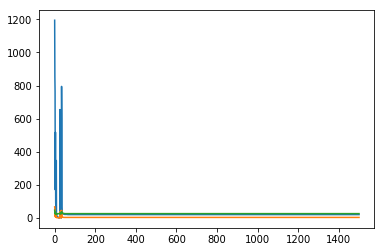

In [7]:
plt.plot(np.array(train_errors))
plt.plot(np.array(validation_errors))
plt.plot(np.array(test_errors))
plt.show()

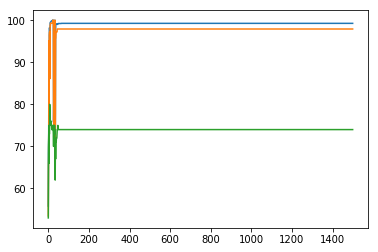

In [8]:
plt.plot(100*(Ntrain-np.array(train_errors))/Ntrain)
plt.plot(100*(Nvalidation-np.array(validation_errors))/Nvalidation)
plt.plot(100*(Ntest-np.array(test_errors))/Ntest)

plt.show()